In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import matplotlib.colors as mcolors

In [4]:
# Load the model and tokenizer
model_name = "openai-community/gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

/usr/local/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [15]:
# Input prompt
prompt = "Kobe Bean Bryant was an American "

# Tokenize the input
inputs = tokenizer(prompt, return_tensors="pt")

# Generate text and logits
max_length = 50
output = model.generate(**inputs, max_length=max_length, return_dict_in_generate=True, output_scores=True)

# Get the generated tokens and scores
generated_tokens = output.sequences[0]
token_scores = torch.stack(output.scores, dim=1)

# Convert scores to probabilities
probs = torch.softmax(token_scores, dim=-1)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


In [16]:
# Calculate entropy for each token
def calculate_entropy(probs):
    return -torch.sum(probs * torch.log2(probs + 1e-10), dim=-1)

entropies = calculate_entropy(probs[0])

# Calculate entropy's upper and lower bounds
vocab_size = model.config.vocab_size
entropy_lower_bound = 0  # Minimum entropy when probability is 1 for one token
entropy_upper_bound = torch.log2(torch.tensor(vocab_size))  # Maximum entropy for uniform distribution

# Normalize entropies using the calculated bounds
normalized_entropies = (entropies - entropy_lower_bound) / (entropy_upper_bound - entropy_lower_bound)

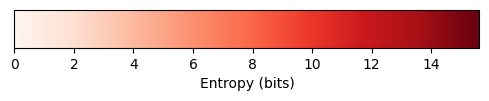

In [75]:
# Generate HTML with colored tokens and alternative predictions
def generate_html(tokens, colors, probs, threshold):
    turbo_cmap = plt.get_cmap('Reds')
    html = ""
    for token, color, prob in zip(tokens, colors, probs):
        rgb = turbo_cmap(color)[:3]
        hex_color = mcolors.rgb2hex(rgb)
        
        # If entropy > threshold, show the second and third best predictions
        if color > threshold:
            top_3 = torch.topk(prob, 3)
            alt_tokens = [tokenizer.convert_tokens_to_string([x]) for x in tokenizer.convert_ids_to_tokens(top_3.indices[1:3])]
            html += f'<span style="color: {hex_color};">{token}[{alt_tokens[0]}, {alt_tokens[1]}]</span>'
        else:
            html += f'<span style="color: {hex_color};">{token}</span>'
    return html

tokens = [tokenizer.decode(token) for token in generated_tokens[len(inputs.input_ids[0]):]]
colors = normalized_entropies.numpy(force=True)
entropy_threshold = 0.5

colored_html = generate_html(tokens, colors, probs[0], entropy_threshold)

display(HTML(f"<p><i>{prompt}</i>{colored_html}</p>"))

# Create a figure for the colorbar
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
cmap = plt.get_cmap('Reds')
norm = plt.Normalize(vmin=entropy_lower_bound, vmax=entropy_upper_bound)
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax, orientation='horizontal')
cbar.set_label('Entropy (bits)', fontsize=10)
plt.show()
